In [ ]:
!pip install scanpy

In [ ]:
# import libraries
import pandas as pd
import scanpy as sc
import numpy as np
import anndata as an
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.svm import SVR
from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score, KFold
import joblib
from sklearn.model_selection import RandomizedSearchCV

In [ ]:
# retrieve subect data from GEO
!wget -O GSM3746212_Muscle_1_Counts.csv.gz 'https://www.ncbi.nlm.nih.gov/geo/download/?acc=GSM3746212&format=file&file=GSM3746212%5FMuscle%5F1%5FCounts%2Ecsv%2Egz'
!wget -O GSM3746213_Muscle_2_Counts.csv.gz 'https://www.ncbi.nlm.nih.gov/geo/download/?acc=GSM3746213&format=file&file=GSM3746213%5FMuscle%5F2%5FCounts%2Ecsv%2Egz'
!wget -O GSM3746214_Muscle_3_Counts.csv.gz 'https://www.ncbi.nlm.nih.gov/geo/download/?acc=GSM3746214&format=file&file=GSM3746214%5FMuscle%5F3%5FCounts%2Ecsv%2Egz'
!wget -O GSM3746215_Muscle_4_Counts.csv.gz 'https://www.ncbi.nlm.nih.gov/geo/download/?acc=GSM3746215&format=file&file=GSM3746215%5FMuscle%5F4%5FCounts%2Ecsv%2Egz'

# decompress files
!gunzip GSM3746212_Muscle_1_Counts.csv.gz
!gunzip GSM3746213_Muscle_2_Counts.csv.gz
!gunzip GSM3746214_Muscle_3_Counts.csv.gz
!gunzip GSM3746215_Muscle_4_Counts.csv.gz

--2024-10-03 15:49:23--  https://www.ncbi.nlm.nih.gov/geo/download/?acc=GSM3746212&format=file&file=GSM3746212%5FMuscle%5F1%5FCounts%2Ecsv%2Egz
Resolving www.ncbi.nlm.nih.gov (www.ncbi.nlm.nih.gov)... 130.14.29.110, 2607:f220:41e:4290::110
Connecting to www.ncbi.nlm.nih.gov (www.ncbi.nlm.nih.gov)|130.14.29.110|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1169603 (1.1M) [application/octet-stream]
Saving to: ‘GSM3746212_Muscle_1_Counts.csv.gz’

GSM3746212_Muscle_1 100%[===================>]   1.12M  6.80MB/s    in 0.2s    

2024-10-03 15:49:24 (6.80 MB/s) - ‘GSM3746212_Muscle_1_Counts.csv.gz’ saved [1169603/1169603]

--2024-10-03 15:49:24--  https://www.ncbi.nlm.nih.gov/geo/download/?acc=GSM3746213&format=file&file=GSM3746213%5FMuscle%5F2%5FCounts%2Ecsv%2Egz
Resolving www.ncbi.nlm.nih.gov (www.ncbi.nlm.nih.gov)... 130.14.29.110, 2607:f220:41e:4290::110
Connecting to www.ncbi.nlm.nih.gov (www.ncbi.nlm.nih.gov)|130.14.29.110|:443... connected.
HTTP request sent

In [ ]:
# read and save subject data as CSV
file_1 = pd.read_csv('GSM3746212_Muscle_1_Counts.csv', index_col=0)
file_2 = pd.read_csv('GSM3746213_Muscle_2_Counts.csv', index_col=0)
file_3 = pd.read_csv('GSM3746214_Muscle_3_Counts.csv', index_col=0)
file_4 = pd.read_csv('GSM3746215_Muscle_4_Counts.csv', index_col=0)

# convert CSV files into standalone AnnData objects
muscle_1 = sc.AnnData(file_1)
muscle_2 = sc.AnnData(file_2)
muscle_3 = sc.AnnData(file_3)
muscle_4 = sc.AnnData(file_4)

# initialize list of AnnData objects, storing ea/ subjects data
adatas = [muscle_1, muscle_2, muscle_3, muscle_4]

# create composite AnnData object
adata_combined = sc.concat(adatas, axis=1, label='sample', keys=['muscle_1', 'muscle_2', 'muscle_3', 'muscle_4'])
adata_combined.var_names_make_unique()

In [ ]:
# transpose AnnData object
adata_transposed = sc.AnnData(adata_combined.T)

In [ ]:
# print summary stats
num_genes = adata_transposed.n_vars # variables = columns (genes)
print(f"Number of Genes: {num_genes}")

num_cells = adata_transposed.n_obs # observations = rows (cells IDs)
print(f"Number of Cells: {num_cells}")

Number of Genes: 15406
Number of Cells: 2876


In [ ]:
# find indices of rows (cell IDs) with NaN values
nan_rows = np.isnan(adata_transposed.X).any(axis=1)
print(f"Number of rows with NaN values: {np.sum(nan_rows)}")

# find indices of columns (genes) with NaN values
nan_cols = np.isnan(adata_transposed.X).any(axis=0)
print(f"Number of columns with NaN values: {np.sum(nan_cols)}")

Number of rows with NaN values: 0
Number of columns with NaN values: 0


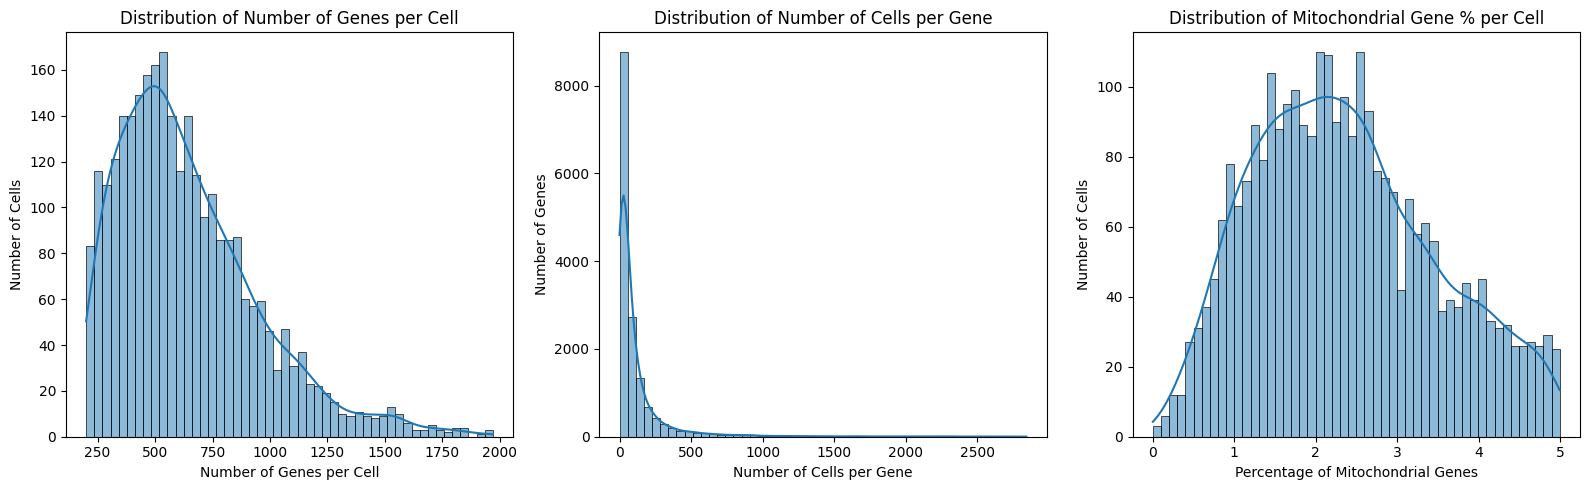

In [ ]:
# calculate the number of genes expressed per cell
adata_transposed.obs['n_genes'] = (adata_transposed.X > 0).sum(axis=1)

# calculate the number of cells in which each gene is expressed
adata_transposed.var['n_cells'] = (adata_transposed.X > 0).sum(axis=0)

# identify mitochondrial genes
mt_gene_mask = adata_transposed.var_names.str.startswith('MT-')

# calculate % mitochondrial genes per cell
if isinstance(adata_transposed.X, np.ndarray):
    adata_transposed.obs['percent_mito'] = np.sum(adata_transposed[:, mt_gene_mask].X, axis=1) / np.sum(adata_transposed.X, axis=1) * 100
else:
    adata_transposed.obs['percent_mito'] = np.sum(adata_transposed[:, mt_gene_mask].X.toarray(), axis=1) / np.sum(adata_transposed.X.toarray(), axis=1) * 100

# create subplots
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# plot histogram of the number of genes per cell
sns.histplot(adata_transposed.obs['n_genes'], bins=50, kde=True, ax=axes[0])
axes[0].set_xlabel('Number of Genes per Cell')
axes[0].set_ylabel('Number of Cells')
axes[0].set_title('Distribution of Number of Genes per Cell')

# plot histogram of the number of cells per gene
sns.histplot(adata_transposed.var['n_cells'], bins=50, kde=True, ax=axes[1])
axes[1].set_xlabel('Number of Cells per Gene')
axes[1].set_ylabel('Number of Genes')
axes[1].set_title('Distribution of Number of Cells per Gene')

# plot the distribution of mito gene %
sns.histplot(adata_transposed.obs['percent_mito'], bins=50, kde=True, ax=axes[2])
axes[2].set_xlabel('Percentage of Mitochondrial Genes')
axes[2].set_ylabel('Number of Cells')
axes[2].set_title('Distribution of Mitochondrial Gene % per Cell')

plt.tight_layout()
plt.show()

In [ ]:
# filter out cells that have fewer than 200 detected genes
sc.pp.filter_cells(adata_transposed, min_genes=200)

# filter out genes that appear in fewer than 20 cells
sc.pp.filter_genes(adata_transposed, min_cells=20)

# print resulting number of cells and genes
num_genes = adata_transposed.n_vars
print(f"Number of Genes: {num_genes}")

num_cells = adata_transposed.n_obs
print(f"Number of cells: {num_cells}")

Number of Genes: 10485
Number of cells: 2876


In [ ]:
# apply global-scaling normalization
sc.pp.normalize_total(adata_transposed, target_sum=1e4)
sc.pp.log1p(adata_transposed)

# find the 2000 most highly variable genes
sc.pp.highly_variable_genes(adata_transposed, n_top_genes=2000, subset=True)
print(adata_transposed)

AnnData object with n_obs × n_vars = 2876 × 2000
    obs: 'sample', 'n_genes'
    var: 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg'


In [ ]:
# apply z-transformation
sc.pp.scale(adata_transposed, zero_center=True)

# perform dimensionality reduction via PCA
sc.tl.pca(adata_transposed, svd_solver='arpack')


In [ ]:
# convert the expression matrix to DF
df = pd.DataFrame(adata_transposed.X, index=adata_transposed.obs_names, columns=adata_transposed.var_names)

In [ ]:
# set first 1,950 genes as inputs
X = df.iloc[:, :1950].values

# choose models to spot-check
models = {
    'LR': Pipeline([('scaler', StandardScaler()), ('model', LinearRegression())]),
    'Ridge': Pipeline([('scaler', StandardScaler()), ('model', Ridge())]),
    'Lasso': Pipeline([('scaler', StandardScaler()), ('model', Lasso())]),
    'ENR': Pipeline([('scaler', StandardScaler()), ('model', ElasticNet())]),
    'CART': Pipeline([('model', DecisionTreeRegressor())]),
    'SVM': Pipeline([('scaler', StandardScaler()), ('model', SVR())]),}

# list to store results for each model
results = []

# iterate over the last 50 output genes and calculate average MSE for each model
kfold = KFold(n_splits=5, random_state=5, shuffle=True)
for name, model in models.items():
    all_mse = []
    for gene_index in range(1950, 2000):
        y = df.iloc[:, gene_index].values
        cv_results = cross_val_score(model, X, y, cv=kfold, scoring='neg_mean_squared_error')
        all_mse.append(-cv_results.mean())
    avg_mse = np.mean(all_mse)
    std_mse = np.std(all_mse)
    results.append({'Model': name, 'Mean_MSE': avg_mse, 'Std_MSE': std_mse})

# convert results list to DF and display DF
results_df = pd.DataFrame(results)
print(results_df)

# visualize the average performance of each model across all genes
plt.figure(figsize=(10, 6))
plt.barh(results_df['Model'], results_df['Mean_MSE'], xerr=results_df['Std_MSE'], capsize=5)
plt.xlabel('Mean MSE')
plt.ylabel('Model')
plt.grid(axis='x')
plt.show()

KeyboardInterrupt: 

In [ ]:
# define the SVR pipeline
svr_pipeline = Pipeline([('scaler', StandardScaler()), ('model', SVR())])

# define the hyperparameter space for random search w/ reduced parameter range
param_distributions = {'model__C': [0.1, 1, 10], 'model__epsilon': [0.01, 0.1], 'model__kernel': ['linear', 'rbf'], 'model__gamma': ['scale', 'auto'],}

random_search = RandomizedSearchCV(estimator=svr_pipeline, param_distributions=param_distributions, n_iter=10, scoring='neg_mean_squared_error', cv=3, random_state=5, verbose=1, n_jobs=-1)

# input values
X = df.iloc[:, :1950].values

# randomly sample 20% of the rows
X_sub, _, y_sub, _ = train_test_split(X, df.iloc[:, 1950].values, test_size=0.8, random_state=5)

# perform random search on the smaller subset
random_search.fit(X_sub, y_sub)

# print the best parameters
print(f"Best parameters on subset: {random_search.best_params_}")
print(f"Best MSE on subset: {-random_search.best_score_}")

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best parameters on subset: {'model__kernel': 'rbf', 'model__gamma': 'auto', 'model__epsilon': 0.01, 'model__C': 10}
Best MSE on subset: 1.1360212346141934


In [ ]:
# separate the target genes (last 50 genes)
target_genes_indices = list(range(1950, 2000))
y = df.iloc[:, target_genes_indices].values
X = df.drop(columns=df.columns[target_genes_indices]).values

# split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# ceate a pipeline with preprocessing and model using optimal hyperparameters
pipeline = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('model', MultiOutputRegressor(SVR(kernel='rbf', C=10, gamma='auto', epsilon=0.01)))])

# fit the pipeline on the training data
pipeline.fit(X_train, y_train)

# save the pipeline to a file for later use
joblib.dump(pipeline, 'gene_expression_pipeline.pkl')

KeyboardInterrupt: 